In [1]:
using PyCall
unshift!(PyVector(pyimport("sys")["path"]), "");
@pyimport Compute_Jacobian_Sioux

In [2]:
numNodes = Compute_Jacobian_Sioux.numNodes;
numLinks = Compute_Jacobian_Sioux.numLinks;
numODpairs = Compute_Jacobian_Sioux.numODpairs;
od_pairs = Compute_Jacobian_Sioux.od_pairs;
link_list_js = Compute_Jacobian_Sioux.link_list_js;
link_length_list = Compute_Jacobian_Sioux.link_length_list;

In [3]:
require("prepare_data_Sioux.jl");
require("extract_data_Sioux.jl");
require("tap_MSA_Sioux.jl");
require("../Julia_files/inverseVI.jl");
require("../Julia_files/demands_adjustment_gradi.jl");

In [4]:
require("initia_data.jl");

In [5]:
demandsDiffDict[1] = norm(demandsDicToVec(demandsDict[1]) - demandsDicToVec(demandsDict[0]))/
                     norm(demandsDicToVec(demandsDict[0]));

In [6]:
fcoeffs = [1, 0, 0, 0, .15];

# get observed flow vector (corresponding to ground truth demands and ground truth costs)
tapFlowDicDict[0], tapFlowVecDict[0] = tapMSA(demandsDict[0], fcoeffs);

In [7]:
# get arcs data corresponding to ground truth demands and flows
arcsDict[0] = observFlow("./benchmark_data/Sioux_net.txt", tapFlowDicDict[0]);

In [8]:
deg = 6
c = 3.41
lam = 1.

coeffs_dict[(deg, c, lam, 1)], objInvVIDict[1] = train(lam, deg, c, demandsDict[1], arcsDict[0]);

In [9]:
# get initial flow vector (corresponding to initial demands)
tapFlowDicDict[1], tapFlowVecDict[1] = tapMSA(demandsDict[1], coeffs_dict[(deg, c, lam, 1)]);

demandsVecDict[0] = demandsDicToVec(demandsDict[0]);

In [10]:
# get arcs data corresponding to initial demands and flows
arcsDict[1] = observFlow("./benchmark_data/Sioux_net.txt", tapFlowDicDict[1]);

In [11]:
linkCostDicDict[1] = tapFlowVecToLinkCostDict(tapFlowVecDict[1], coeffs_dict[(deg, c, lam, 1)]);

In [12]:
linkCostDicDict[1]["0"], link_length_list[1]

(6.025942778478786,6.0)

In [13]:
jacobiSpiessDict[1] = Compute_Jacobian_Sioux.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[1]["$(i)"] for i=0:numLinks-1]);

In [14]:
# maximum number of iterations
N = 50;  

# Armijo rule parameters
rho = 2;
M = 10;

# search direction parameter
epsilon_1 = 0;

# stop criterion parameter
epsilon_2 = 1e-20;

In [15]:
for iterNumber = 1:N
    
    l = iterNumber;
    
    jacobDict[l] = jacobiSpiessDict[l]

    descDirecDict[l] = descDirec(tapFlowVecDict[l], tapFlowVecDict[0], jacobDict[l], numODpairs, numLinks);

    demandsVecDict[l] = demandsDicToVec(demandsDict[l]);

    searchDirecDict[l] = searchDirec(demandsVecDict[l], descDirecDict[l], epsilon_1);

    thetaMaxDict[l] = thetaMax(demandsVecDict[l], searchDirecDict[l]);

    objFunDict[l] = objF(demandsVecDict[l]);

    demandsVecDict[l+1] = similar(demandsVecDict[0]);
    
    demandsVecDict[l+1], objFunDict[l+1] = armijo(demandsVecDict[l], searchDirecDict[l], thetaMaxDict[l], rho, M);
            
    demandsDict[l+1] = demandsVecToDic(demandsVecDict[l+1]);
    
    tapFlowDicDict[l+1], tapFlowVecDict[l+1] = tapMSA(demandsDict[l+1], coeffs_dict[(deg, c, lam, l)]);
        
    arcsDict[l+1] = observFlow("./benchmark_data/Sioux_net.txt", tapFlowDicDict[l+1]);
        
    coeffs_dict[(deg, c, lam, l+1)], objInvVIDict[l+1] = train(lam, deg, c, demandsDict[l+1], arcsDict[0]);

    linkCostDicDict[l+1] = tapFlowVecToLinkCostDict(tapFlowVecDict[l+1], coeffs_dict[(deg, c, lam, l+1)]);
    
    jacobiSpiessDict[l+1] = Compute_Jacobian_Sioux.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[l+1]["$(i)"] for i=0:numLinks-1]);
        
    demandsDiffDict[l+1] = norm(demandsVecDict[l+1] - demandsVecDict[0]) / norm(demandsVecDict[0]);
    
    # stopping criterion
    if (objFunDict[l] - objFunDict[l+1]) / objFunDict[1] < epsilon_2
        break
    end
        
end

# normalize objective function value
for l = 1:(length(objFunDict))
    norObjFunDict[l] = objFunDict[l] / objFunDict[1];
end

In [16]:
demandsVecDict

Dict{Int64,Array{Float64,1}} with 39 entries:
  18 => [50.93631005144979,115.70318875265755,460.7586647608638,215.816521798332…
  30 => [53.525673609365306,117.18354752401846,462.75394177360675,215.5286261400…
  33 => [54.754959806674336,117.57906628690498,462.99264989868755,215.1205199408…
  32 => [54.00219995861912,117.31931754799639,462.84094710441894,215.35416933640…
  2  => [96.62243574776011,110.04131368578079,446.9268161411662,218.119038980438…
  16 => [51.97235257506386,116.25655512865683,461.3548817253748,217.274826265125…
  11 => [76.2265373100084,115.24743071358266,453.86805017028735,213.690055287866…
  21 => [51.63882401658451,117.04564239458662,462.5357926819222,216.475754484170…
  0  => [100.0,100.0,500.0,200.0,300.0,500.0,800.0,500.0,1300.0,500.0,200.0,500.…
  7  => [86.9878639449794,112.14449068502503,449.0707731246577,212.8598070022026…
  9  => [79.49633736620896,114.44535774082608,452.33320172774523,212.75940666005…
  10 => [76.76313359271788,115.15586795305659,453.67

In [17]:
norObjFunDict

Dict{Int64,Float64} with 38 entries:
  18 => 0.04396309971811811
  30 => 0.01078105072578065
  33 => 0.007646559126894711
  32 => 0.00988494309399057
  2  => 0.717491434440112
  16 => 0.06800257877619188
  11 => 0.26389146925763174
  21 => 0.02383734476533928
  7  => 0.4322528610442085
  9  => 0.3077080535340029
  25 => 0.019464309894201445
  10 => 0.27327364498490897
  26 => 0.018010894358349457
  29 => 0.011289938717882779
  34 => 0.007182501076800239
  35 => 0.007005275715787952
  19 => 0.033708723947816904
  17 => 0.05418449149886161
  8  => 0.4066892127999087
  22 => 0.020895188452323403
  6  => 0.46932669948437294
  24 => 0.01970750602640548
  4  => 0.6786236328404471
  37 => 0.005785279648491873
  3  => 0.6838174906684064
  ⋮   => ⋮

INFO: Loading help data...


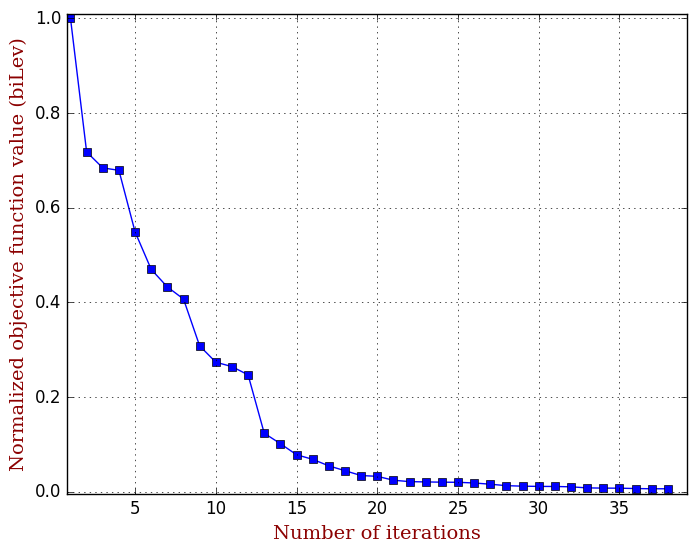

In [18]:
using PyPlot

iterNum = 1:(length(norObjFunDict))

objFun = map(iterNum->norObjFunDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "s-b")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, length(norObjFunDict) + 1 + .2)
ylim(minimum(objFun)-.01, maximum(objFun)+.01)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized objective function value (biLev)", fontdict=font1)

savefig("./results/objFun_biLev_Sioux.pdf")

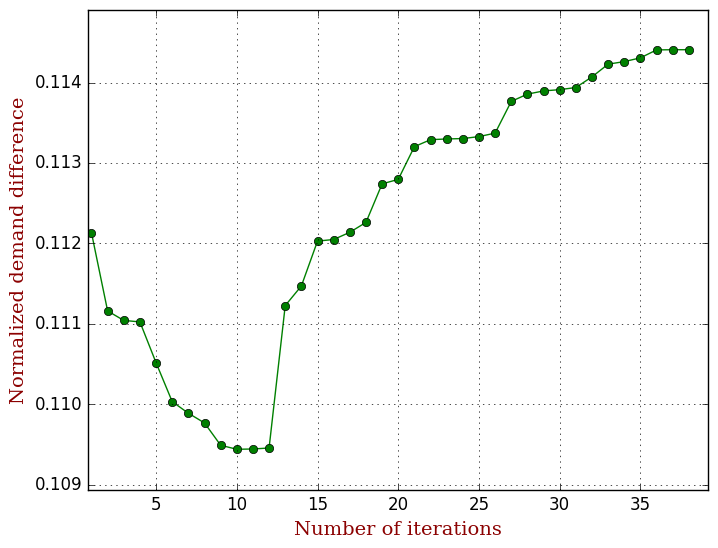

In [19]:
using PyPlot

iterNum = 1:(length(demandsDiffDict))

demandsDiff = map(iterNum->demandsDiffDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, demandsDiff, "o-g")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, length(demandsDiffDict) + 1 + .2)
ylim(minimum(demandsDiff)-.0005, maximum(demandsDiff)+.0005)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized demand difference", fontdict=font1)

savefig("./results/demandsDiff_biLev_Sioux.pdf")

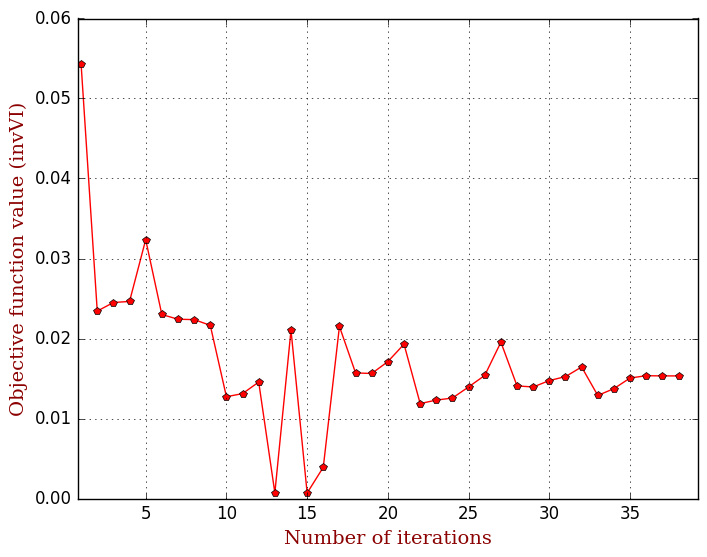

In [20]:
using PyPlot

iterNum = 1:(length(objInvVIDict))

objFun = map(iterNum->objInvVIDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "p-r")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(0.8, length(objInvVIDict) + 1 + .2)
# ylim(0.9, 2.0)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Objective function value (invVI)", fontdict=font1)

savefig("./results/objFun_invVI_Sioux.pdf")

In [21]:
coeffs_dict

Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}} with 38 entries:
  (6,3.41,1.0,6)  => [1.0,0.029651833898378784,-0.12457432027200775,0.1284296884…
  (6,3.41,1.0,11) => [1.0,0.010539785089024782,-0.05903701905399056,0.0854785879…
  (6,3.41,1.0,20) => [1.0,0.01954214333484851,-0.09089616000000714,0.11003578587…
  (6,3.41,1.0,21) => [1.0,0.030221046667308325,-0.1283594246415276,0.13766405099…
  (6,3.41,1.0,25) => [1.0,0.012602797078918218,-0.06713867010841598,0.0947227408…
  (6,3.41,1.0,13) => [1.0,0.025761979111133013,-0.086254864265976,0.114006251440…
  (6,3.41,1.0,30) => [1.0,0.01586413746959898,-0.07866054386095464,0.10353780387…
  (6,3.41,1.0,3)  => [1.0,0.029377527461326686,-0.12348544286552121,0.1277175495…
  (6,3.41,1.0,10) => [1.0,0.010557478636376818,-0.059115125399159786,0.085603443…
  (6,3.41,1.0,35) => [1.0,0.016139229202675787,-0.07968409536393946,0.1045367080…
  (6,3.41,1.0,8)  => [1.0,0.02967017803950111,-0.12465009571887081,0.12849176825…
  (6,3.41,1.0,15) => [1.0,-0

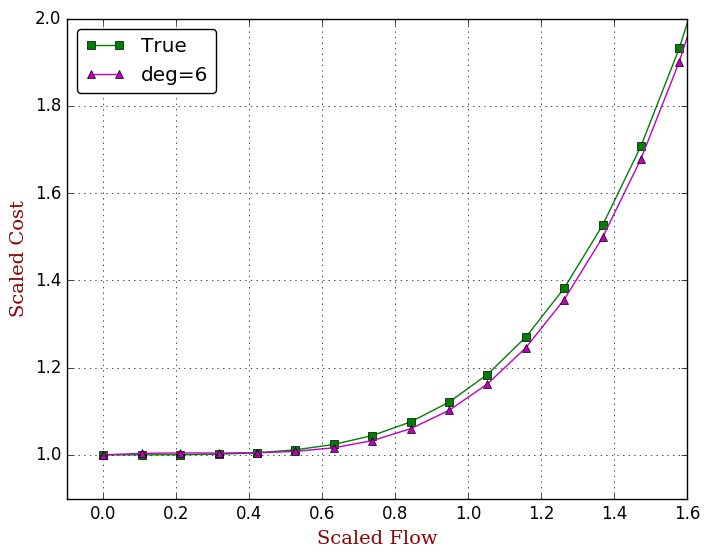

In [22]:
using PyPlot

iterN = 1

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

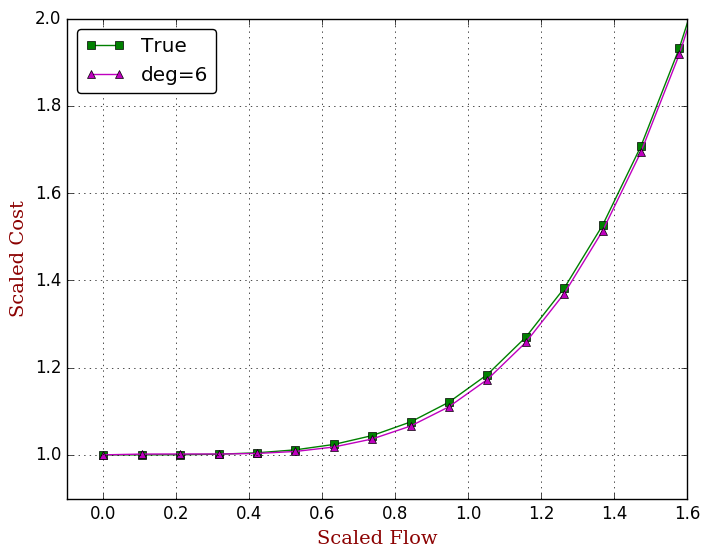

In [23]:
using PyPlot

iterN = 2

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

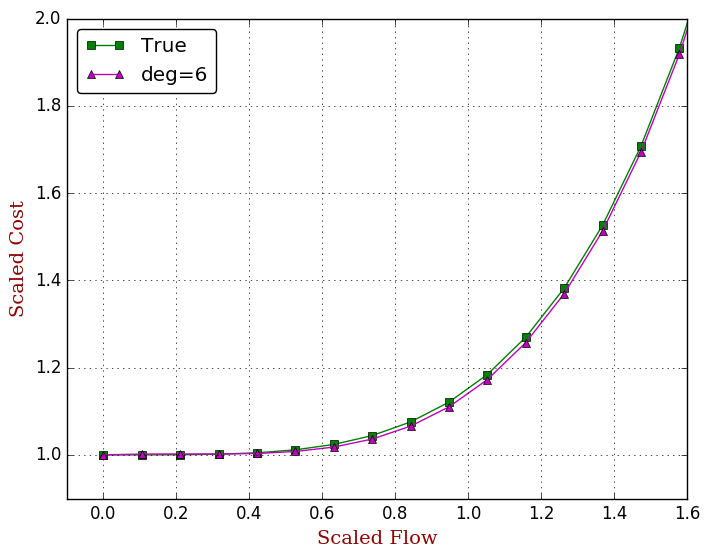

In [24]:
using PyPlot

iterN = 3

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

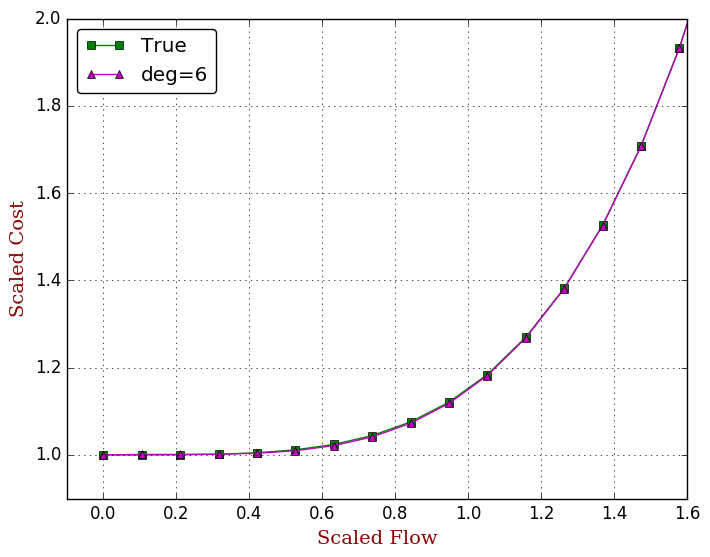

In [25]:
using PyPlot

iterN = length(coeffs_dict)

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

In [26]:
outfile = open("./results/norObjFunDict.json", "w")

JSON.print(outfile, norObjFunDict)

close(outfile)

In [27]:
outfile = open("./results/demandsDiffDict.json", "w")

JSON.print(outfile, demandsDiffDict)

close(outfile)

In [28]:
outfile = open("./results/objInvVIDict.json", "w")

JSON.print(outfile, objInvVIDict)

close(outfile)

In [29]:
outfile = open("./results/coeffs_dict.json", "w")

JSON.print(outfile, coeffs_dict)

close(outfile)

In [30]:
outfile = open("./results/demandsVecDict.json", "w")

JSON.print(outfile, demandsVecDict)

close(outfile)

In [31]:
outfile = open("./results/demandsDict.json", "w")

JSON.print(outfile, demandsDict)

close(outfile)

In [32]:
outfile = open("./results/tapFlowDicDict.json", "w")

JSON.print(outfile, tapFlowDicDict)

close(outfile)

In [33]:
outfile = open("./results/tapFlowVecDict.json", "w")

JSON.print(outfile, tapFlowVecDict)

close(outfile)